In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import requests 
import os 
import datetime
from scipy import stats
import netCDF4 as nc
import scipy.optimize as opt
from mpl_toolkits.basemap import Basemap

In [2]:
stn_coord=pd.read_csv('../data/observation/coords.csv')
stn=stn_coord['stn']
stn_lat=stn_coord['lat']
stn_lon=stn_coord['lon']

In [3]:
# Daily visibility data for 47 stations in Nigeria from Dec 2021 to Mar 2022
vis=pd.read_csv('../data/observation/vis_12_2021_03_2022.csv', index_col=[0])
vis.index=pd.to_datetime(vis.index, format='%d/%m/%Y')
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,13.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,16.0,6.0,20.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,20.0,7.0,NaN,10.0,20.0,20.0,1.0,3.0,NaN
2021-12-03,10.0,13.0,3.0,13.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,20.0,3.0,15.0,7.0,20.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,12.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,15.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [4]:
# cap visibility maximum to 10km
# training set from Dec 2021 to Jan 2022, possible to add Feb?, validation for Mar??
vis.columns
for i in vis.columns:
    vis[i]=np.where(vis[i]>10, 10, vis[i])
vis_train=vis.iloc[:90]
vis_test=vis.iloc[90:]
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,10.0,6.0,10.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,10.0,7.0,NaN,10.0,10.0,10.0,1.0,3.0,NaN
2021-12-03,10.0,10.0,3.0,10.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,10.0,3.0,10.0,7.0,10.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,10.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,10.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [5]:
bsc = xr.open_dataset("../data/models/BSC_DREAM8b_V2/20211201_BSC_DREAM8b_V2.nc")
bsc

<xarray.Dataset>
Dimensions:     (longitude: 500, latitude: 250, level: 24, time: 25)
Coordinates:
  * longitude   (longitude) float32 -63.0 -62.67 -62.33 ... 102.7 103.0 103.3
  * latitude    (latitude) float32 -11.0 -10.67 -10.33 ... 71.33 71.67 72.0
  * level       (level) float32 86.0 275.0 495.0 ... 1.356e+04 1.502e+04
  * time        (time) datetime64[ns] 2021-12-01T12:00:00 ... 2021-12-04T12:0...
Data variables:
    OD550_DUST  (time, latitude, longitude) float32 ...
    SCONC_DUST  (time, latitude, longitude) float32 ...
    LOAD_DUST   (time, latitude, longitude) float32 ...
    EMI_DUST    (time, latitude, longitude) float32 ...
    PM10_DUST   (time, latitude, longitude) float32 ...
Attributes:
    Model:    BSC-DREAM8b.v2 with calibration factor in the output of 2

In [6]:
# ('BSC_DREAM8b_V2', 'SCONC_DUST', (7, 15), 1000000000)

In [7]:
nc_files = os.listdir(f"../data/models/BSC_DREAM8b_V2")
nc_files[0]

'20211201_BSC_DREAM8b_V2.nc'

In [8]:
# sconc_dust #
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("../data/models/BSC_DREAM8b_V2/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.SCONC_DUST.time.to_series()[7]]]
    for i in range(len(stn)):
        day1_bsc = bsc.SCONC_DUST.isel(time = 7).sel(latitude = stn_lat[i], 
                                                     longitude = stn_lon[i], 
                                                     method = 'nearest')*1000000000
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        on = ["stn", "lon", "lat"], 
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

,stn,lon,lat,2021-12-02 09:00:00,2021-12-03 09:00:00,2021-12-04 09:00:00,2021-12-05 09:00:00,2021-12-08 09:00:00,2021-12-09 09:00:00,2021-12-10 09:00:00,...,2022-03-20 09:00:00,2022-03-21 09:00:00,2022-03-24 09:00:00,2022-03-26 09:00:00,2022-03-27 09:00:00,2022-03-28 09:00:00,2022-03-29 09:00:00,2022-03-30 09:00:00,2022-03-31 09:00:00,2022-04-01 09:00:00
0,ABE,3.33,7.20,3.113139,3.259104,5.346566,7.075728,10.458887,22.126107,67.422548,...,4.946295,2.222917,0.668211,1.617843,2.191581,0.043170,0.043170,0.043170,0.043170,0.043170
1,ABK,8.19,6.25,6.649194,8.917035,13.201324,38.605023,99.767611,89.725098,134.567415,...,4.548445,11.642174,6.759899,9.590504,14.664980,0.001160,0.001160,0.001160,0.001160,0.001160
2,ABU,7.20,9.00,97.292684,143.339818,130.823494,128.720018,126.493063,91.288072,120.162241,...,57.026508,36.969826,21.436970,149.621712,143.954935,2.241252,2.241252,2.241252,2.241252,2.241252
3,ADO,5.20,7.60,28.930730,64.132877,50.760246,100.425979,109.045232,96.213363,89.850786,...,10.491892,6.387220,4.183767,9.765944,10.856641,0.003278,0.003278,0.003278,0.003278,0.003278
4,AKU,5.30,7.20,12.796250,32.251602,23.327637,65.020153,74.502054,83.299810,81.426499,...,9.272950,6.027422,2.660447,9.154784,9.271455,0.005334,0.005334,0.005334,0.005334,0.005334
5,ASA,6.23,6.82,4.327217,8.728993,8.746214,19.474079,19.177611,42.451909,63.874538,...,3.363023,4.459255,5.905990,6.262018,6.677085,0.029034,0.029034,0.029034,0.029034,0.029034
6,AWK,7.07,6.20,3.121064,5.577502,6.166992,14.473811,19.249349,40.032848,73.359359,...,3.579131,7.601675,8.789327,7.461849,7.073794,0.033133,0.033133,0.033133,0.033133,0.033133
7,BAU,9.82,10.28,279.904981,267.254649,218.752589,172.221505,150.713404,280.274293,392.847340,...,95.785758,70.702839,357.697104,354.235965,436.339832,72.389852,72.389852,72.389852,72.389852,72.389852
8,BEN,5.60,6.33,1.241337,2.705962,2.247323,4.593527,3.919716,17.486720,36.900161,...,1.266016,1.505773,4.310770,3.019665,1.064124,0.009924,0.009924,0.009924,0.009924,0.009924
9,BID,6.00,9.80,147.979947,185.337257,161.719214,147.299545,149.081771,105.381147,203.865625,...,63.317373,34.029654,16.152290,186.881678,218.388877,3.707580,3.707580,3.707580,3.707580,3.707580


In [9]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()

day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d")
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t.head()

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
index,,,,,,,,,,,,,,,,,,,,,
2021-12-02,3.113139,6.649194,97.292684,28.93073,12.79625,4.327217,3.121064,279.904981,1.241337,147.979947,...,483.272515,43.530786,153.521299,3.97665,0.293577,0.136987,155.996631,0.178879,152.117337,277.988818
2021-12-03,3.259104,8.917035,143.339818,64.132877,32.251602,8.728993,5.577502,267.254649,2.705962,185.337257,...,273.918602,46.414055,182.299004,3.825373,0.625204,0.848169,182.416713,0.785198,205.368551,261.437179
2021-12-04,5.346566,13.201324,130.823494,50.760246,23.327637,8.746214,6.166992,218.752589,2.247323,161.719214,...,227.128979,70.028683,189.247956,7.98572,2.553037,0.460161,167.103593,3.165176,145.886261,212.436106
2021-12-05,7.075728,38.605023,128.720018,100.425979,65.020153,19.474079,14.473811,172.221505,4.593527,147.299545,...,168.660847,105.587262,134.715933,12.443267,3.50752,2.185969,143.738831,7.877165,108.946836,170.538655
2021-12-08,10.458887,99.767611,126.493063,109.045232,74.502054,19.177611,19.249349,150.713404,3.919716,149.081771,...,168.452985,86.187363,115.408298,17.144979,1.526315,1.328855,141.769206,0.619895,144.706391,135.980116


In [10]:
# cor_ls = []

# fig = plt.figure(figsize=(20, 24))

# def exp_func(x, a, b, c, d):
#     return a * np.exp(-b * x) + c + d*x

# for i, j in enumerate(stn):
#     merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
#     merged.columns = ["Visibility", "AOD"]
#     merged['AOD'] = pd.to_numeric(merged['AOD'], errors='coerce') # convert to numeric type
#     ab = merged.dropna()

#     # exponential regression part
#     popt, pcov = opt.curve_fit(exp_func, ab['AOD'], ab['Visibility'], maxfev=10000)
#     exp_fit = exp_func(ab['AOD'], *popt)

#     # calculate correlation
#     corr = np.corrcoef(ab['AOD'], ab['Visibility'])[0,1]
#     p_val = stats.pearsonr(ab['AOD'], ab['Visibility'])[1]

#     cor_ls.append([stn_lat[i], stn_lon[i], j, round(corr, 2), round(p_val, 2)])

#     ax = fig.add_subplot(8,6,i+1)
#     ax.scatter(ab['AOD'], ab['Visibility'], color='k')
    
#     x_fitted = np.linspace(np.min(ab['AOD']), np.max(ab['AOD']), 100)
#     a = popt[0]
#     b = popt[1]
#     c = popt[2]
#     d = popt[3]
#     y_fitted = a * np.exp(-b * x_fitted) + c + d*x_fitted
    
#     ax.plot(x_fitted, y_fitted, 'r')
# #     title = j + '\n a={:.2f}, b={:.2f}, c={:.2f}, d={:.2f}\n'.format(*popt) + 'corr={:.2f}, p-value={:.2f}'.format(corr, p_val)
# #     ax.set_title(title, fontsize=14)
#     ax.set_ylim([-1, 11])
#     ax.margins(y=0.2)
    
# #     ax.set_xlim([0, 1.5])
# #     ax.set_ylim([-1, 11])
# #     ax.margins(x=0.05, y=0.2)
#     equation = j + '; ' + f'r = {corr:.2f} \n' + f'y = {popt[1]:.2f}e^({-popt[2]:.2f}x) + \n{popt[3]:.2f}x + {popt[0]:.2f}'

# #     ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=12, verticalalignment='top')
#     ax.set_title(equation, fontsize=12)


# plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.95, bottom=0.05, left=0.05, right=0.95)
# # fig.suptitle('Relationship Between Aerosol Optical Depth (AOD) and Visibility', fontsize=20)
# fig.supxlabel('Aerosol Optical Depth (AOD)', fontsize=16)
# fig.supylabel('Visibility (km)', fontsize=16)
# plt.savefig('../plots/day1/BSC_DREAM8b_V2.png')

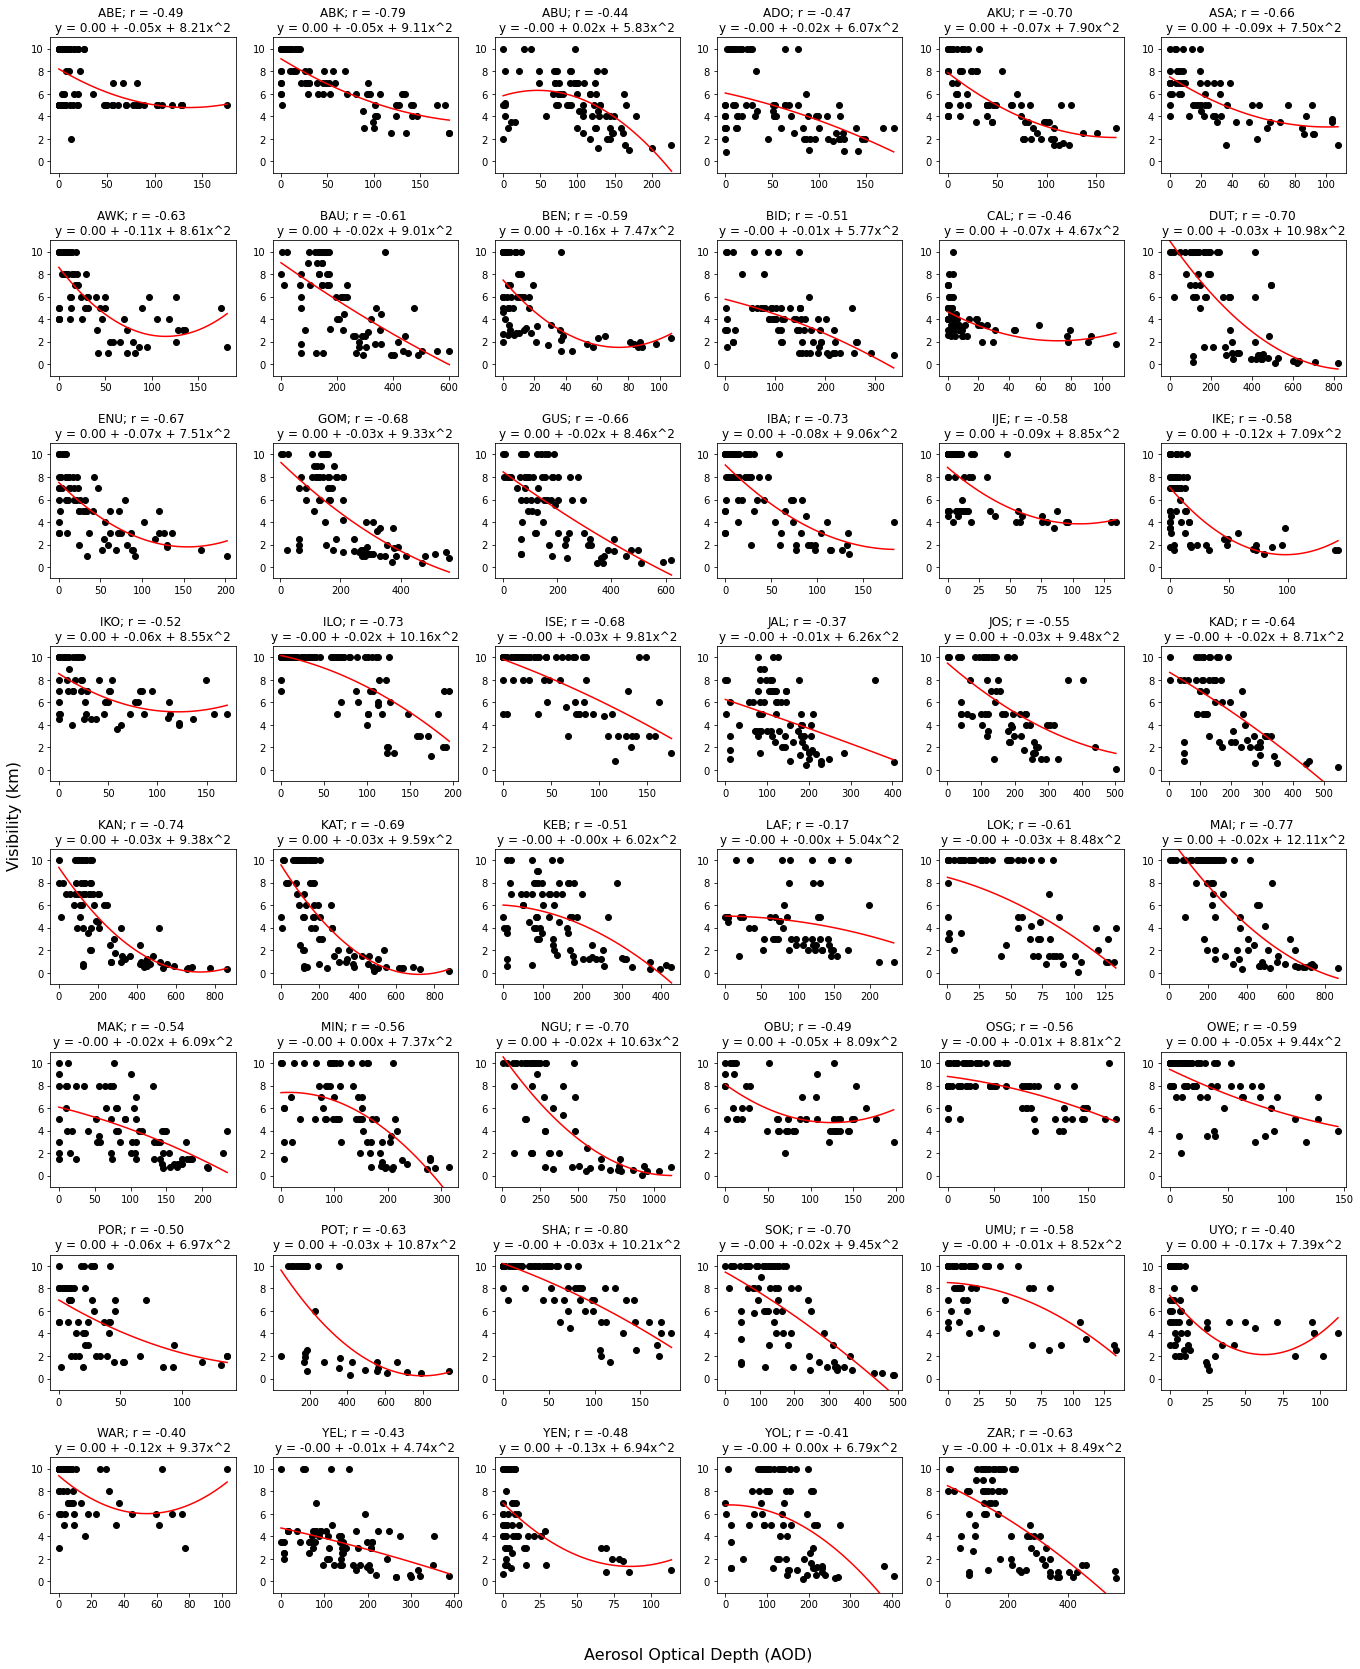

In [11]:
# polynomial regression 

cor_ls = []

fig = plt.figure(figsize=(20, 24))

def poly_func(x, *coeff):
    return np.polyval(coeff, x)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    merged['AOD'] = pd.to_numeric(merged['AOD'], errors='coerce') # convert to numeric type
    ab = merged.dropna()

    # polynomial regression part
    coeff = np.polyfit(ab['AOD'], ab['Visibility'], deg=2)
    poly_fit = poly_func(ab['AOD'], *coeff)

    # calculate correlation
    corr = np.corrcoef(ab['AOD'], ab['Visibility'])[0,1]
    p_val = stats.pearsonr(ab['AOD'], ab['Visibility'])[1]

    cor_ls.append([stn_lat[i], stn_lon[i], j, round(corr, 2), round(p_val, 2)])

    ax = fig.add_subplot(8,6,i+1)
    ax.scatter(ab['AOD'], ab['Visibility'], color='k')
    
    x_fitted = np.linspace(np.min(ab['AOD']), np.max(ab['AOD']), 100)
    y_fitted = poly_func(x_fitted, *coeff)
    
    ax.plot(x_fitted, y_fitted, 'r')
    
    ax.set_ylim([-1, 11])
    ax.margins(y=0.2)
    
    equation = j + '; ' + f'r = {corr:.2f} \n' + f'y = {coeff[0]:.2f} + {coeff[1]:.2f}x + {coeff[2]:.2f}x^2'

    ax.set_title(equation, fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.95, bottom=0.05, left=0.05, right=0.95)
fig.supxlabel('Aerosol Optical Depth (AOD)', fontsize=16)
fig.supylabel('Visibility (km)', fontsize=16)
plt.savefig('../plots/day1/BSC_DREAM8b_V2_poly.png')


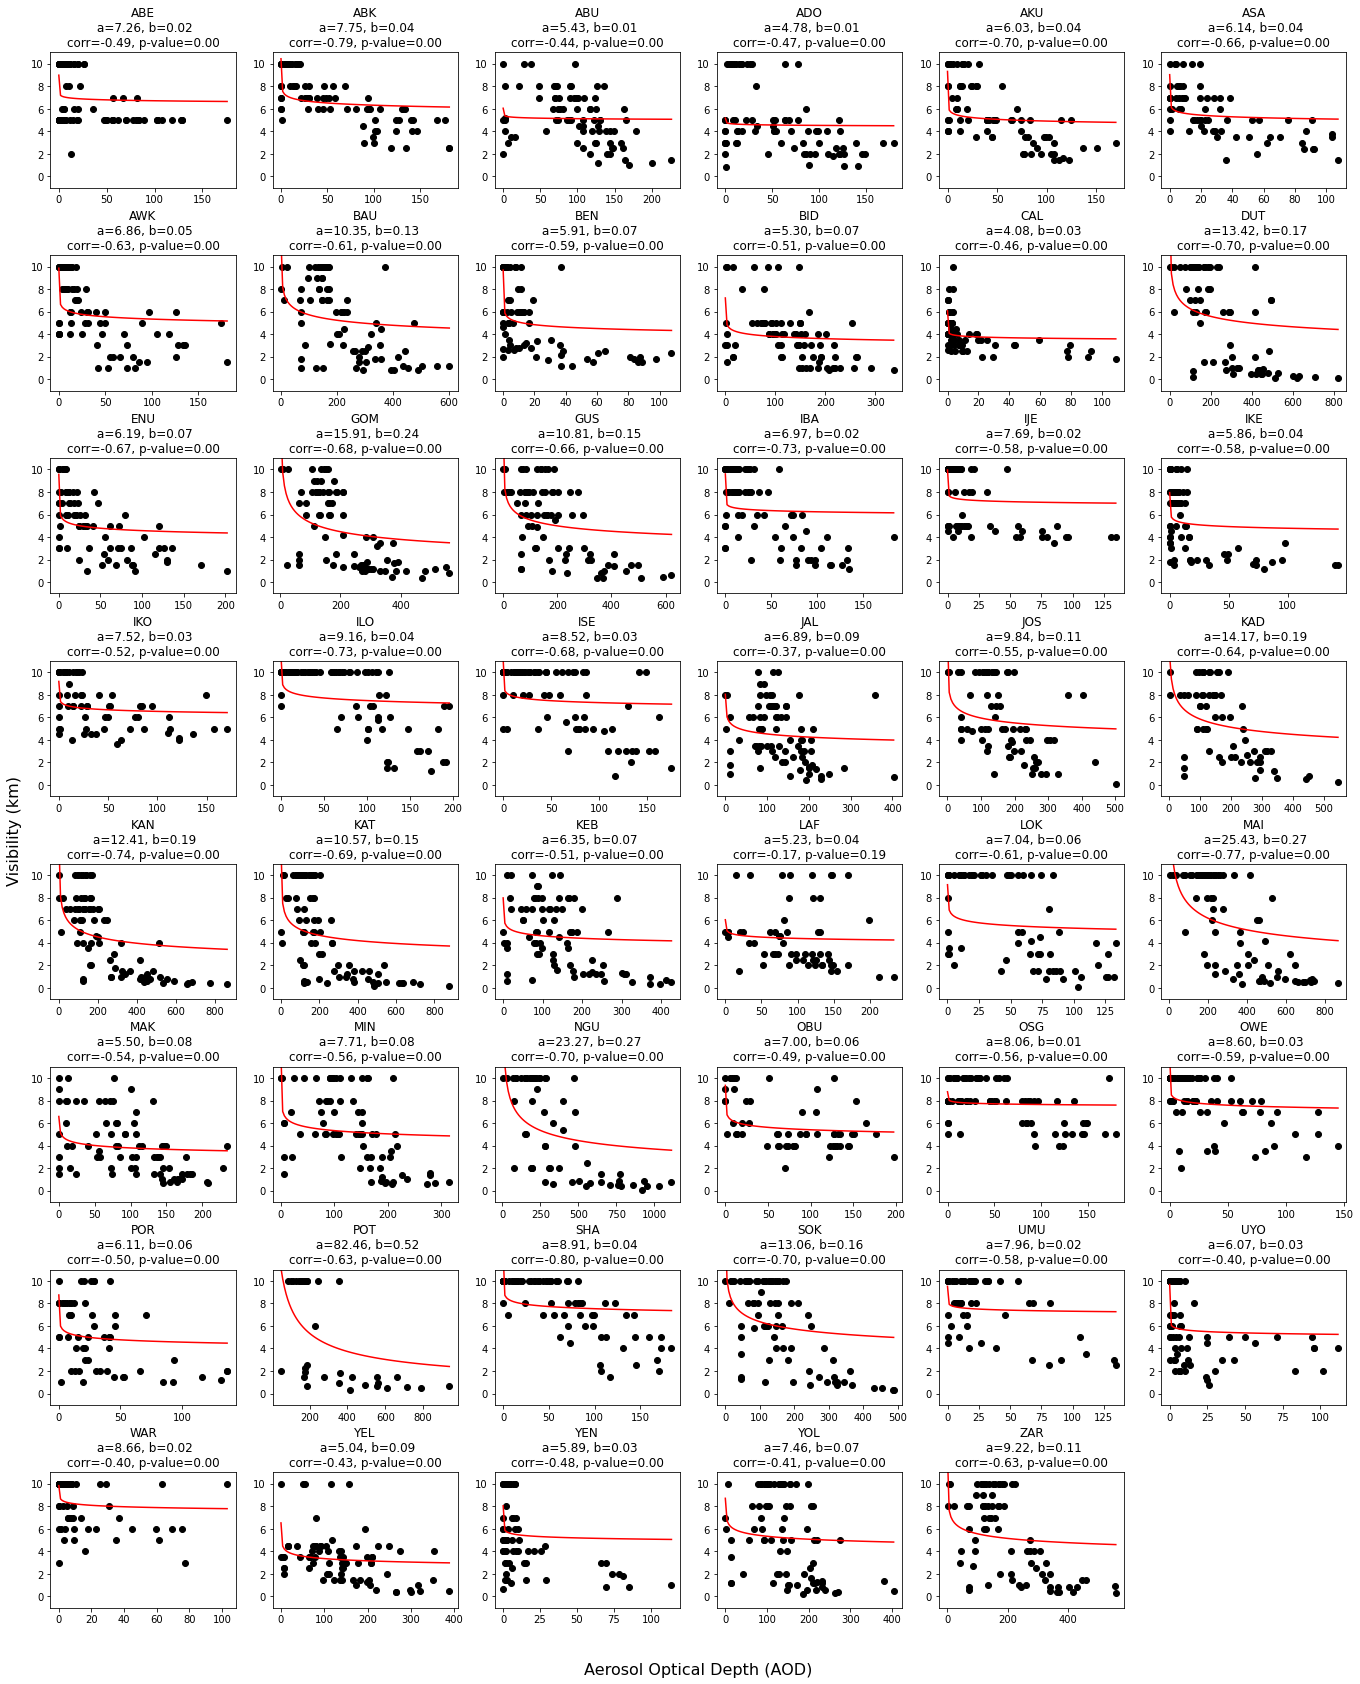

In [12]:
# power law

cor_ls = []

fig = plt.figure(figsize=(20, 24))

def power_law_func(x, a, b):
    return a * x ** (-b)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    merged['AOD'] = pd.to_numeric(merged['AOD'], errors='coerce') # convert to numeric type
    ab = merged.dropna()

    # power law regression part
    popt, pcov = opt.curve_fit(power_law_func, ab['AOD'], ab['Visibility'])
    power_law_fit = power_law_func(ab['AOD'], *popt)

    # calculate correlation
    corr = np.corrcoef(ab['AOD'], ab['Visibility'])[0,1]
    p_val = stats.pearsonr(ab['AOD'], ab['Visibility'])[1]

    cor_ls.append([stn_lat[i], stn_lon[i], j, round(corr, 2), round(p_val, 2)])

    ax = fig.add_subplot(8,6,i+1)
    ax.scatter(ab['AOD'], ab['Visibility'], color='k')
    
    x_fitted = np.linspace(np.min(ab['AOD']), np.max(ab['AOD']), 100)
    a = popt[0]
    b = popt[1]
    y_fitted = a * x_fitted ** (-b)
    
    ax.plot(x_fitted, y_fitted, 'r')
    ax.set_title(j + '\n a={:.2f}, b={:.2f}\n'.format(*popt) + 'corr={:.2f}, p-value={:.2f}'.format(corr, p_val), fontsize=12)
    ax.set_ylim([-1, 11])
    ax.margins(y=0.2)

plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.95, bottom=0.05, left=0.05, right=0.95)
fig.supxlabel('Aerosol Optical Depth (AOD)', fontsize=16)
fig.supylabel('Visibility (km)', fontsize=16)
plt.savefig('../plots/day1/BSC_DREAM8b_V2_power.png')


In [ ]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
# cor_df

# cor_df.to_csv("cor_files/day1/MULTI MODEL MEDIAN_1d.csv", index=False)
cor_df.to_csv("../plots/day1/BSC_DREAM8b_V2.csv", index=False)
# cor_df.to_csv("cor_files/day3/MULTI MODEL MEDIAN_3d.csv", index=False)